In [9]:
import pandas as pd
train= pd.read_csv('korean-hate-speech/labeled/train.tsv' ,sep='\t')
dev= pd.read_csv('korean-hate-speech/labeled/dev.tsv' ,sep='\t')

# 독립변수 처리

In [10]:
train = train[['comments','hate']]
train['hate'] = train['hate'].map({'none':0,'offensive':1,'hate':2})
dev = dev[['comments','hate']]
dev['hate'] = dev['hate'].map({'none':0,'offensive':1,'hate':2})

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
print('훈련용 리뷰의 개수 :', len(train))
print('테스트용 리뷰의 개수 :', len(dev))

훈련용 리뷰의 개수 : 7896
테스트용 리뷰의 개수 : 471


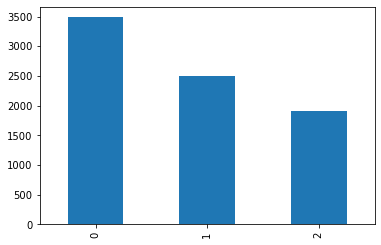

In [13]:
train['hate'].value_counts().plot(kind = 'bar')

# 불용어 제거 후 토큰화 작업

- ( , ) 도 추가
- ....은 의미 있을 수도 있어 제거 X

In [14]:
stopwords = ['(',')','도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '음', '면']

In [15]:
mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")

train['tokenized'] = train['comments'].apply(mecab.morphs)
train['tokenized'] = train['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
dev['tokenized'] = dev['comments'].apply(mecab.morphs)
dev['tokenized'] = dev['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [16]:
train

,comments,hate,tokenized
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,2,"[현재, 호텔, 주인, 심정, 아, 18, 난, 마른, 하늘, 날벼락, 맞, 호텔,..."
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,0,"[...., 한국, 적, 미인, 대표, 적, 분, ., .., 너무나, 곱, 아름다..."
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",2,"[..., 못된, 넘, ., .., 남, 고통, 즐겼, 던, 넘, ., ., 이젠,..."
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",0,"[1, ,, 2, 화, 어설펐, 는데, 3, ,, 4, 화, 지나, 서, 부터, 갈..."
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,2,"[1, ., 사람, 얼굴, 손톱, 으로, 긁, 것, 인격, 살해, 2, ., 동영상..."
...,...,...,...
7891,힘내세요~ 응원합니다!!,0,"[힘내, 세요, ~, 응원, 합니다, !, !]"
7892,힘내세요~~삼가 고인의 명복을 빕니다..,0,"[힘내, 세요, ~~, 삼가, 고인, 명복, 빕, 니다, ., .]"
7893,힘내세용 ^^ 항상 응원합니닷 ^^ !,0,"[힘내, 세용, ^^, 항상, 응, 원합, 니, 닷, ^^, !]"
7894,힘내소...연기로 답해요.나도 53살 인데 이런일 저런일 다 있더라구요.인격을 믿습...,0,"[힘내, 소, ., .., 연기, 로, 답, 해요, ., 나, 53, 살, 인데, ..."


In [17]:
# sum 해주기 위한 전처리 (쉼표 및 문장간 띄어쓰기 입력)
train['tokenized'] = train['tokenized'].apply(lambda x: str(x).replace('[','').replace("'",'').replace(']',' ').replace(',',''))
dev['tokenized'] = dev['tokenized'].apply(lambda x: str(x).replace('[','').replace("'",'').replace(']',' ').replace(',',''))

In [18]:
all_words = train['tokenized'].sum()

In [19]:
all_words = all_words.split(' ')
print("현재 train 에 존재하는 모든 단어 수는", len(all_words))

현재 train 에 존재하는 모든 단어 수는 123282


In [20]:
# 추후 max_features로 사용
print("현재 train 에 존재하는 중복 제거한 단어 수는",len(set(all_words)))

현재 train 에 존재하는 중복 제거한 단어 수는 13774


# TF-IDF 적용

- 단순히 단어 코퍼스에서의 빈도 수뿐만 아니라 문서 내에 그 단어가 얼마나 중요한지의 의미를 고려한 방법론
- 이는 특정 문서에서 상대적 빈도를 나타내는 TF와 전체 문서에 존재하는 해당 단어의 비율을 반비례한 IDF를 곱한 개념
- 즉, 관사나 형용사처럼 공통적인 단어보다 하나의 작은 그룹에서 존재하는 흔한 단어들이 더 높은 TF-IDF값


- 이를 활용하면, 3가지 부류에 속하는 공통적인 단어는 TF-IDF값이 낮기 때문에 쉽게 제거할 수 있지 않을까 라는 아이디어에서 고안
- **즉 빈도 수도 많으며 해당 부류의 특성까지 반영한 단어를 확인해보자.**

In [21]:
none_words = train[train.hate == 0]['tokenized'].sum()
offensive_words = train[train.hate == 1]['tokenized'].sum()
hate_words = train[train.hate == 2]['tokenized'].sum()

In [22]:
corpus = none_words, offensive_words, hate_words

In [163]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=12191, stop_words='english')
tdm = tfidf.fit_transform(corpus)
word_count = pd.DataFrame({
    '단어': tfidf.get_feature_names(),
    'TF-IDF값': tdm.sum(axis=0).flat
})
word_count

,단어,TF-IDF값
0,0000000003,0.001588
1,07,0.001588
2,10,0.046180
3,100,0.011913
4,1000,0.004410
...,...,...
12186,힘들,0.077027
12187,힘듦도,0.001983
12188,힘써,0.001588
12189,힘쎈,0.001983


In [175]:
tf_idf_df = word_count.sort_values('TF-IDF값', ascending=False)
tf_idf_df

,단어,TF-IDF값
322,ㅋㅋ,0.888532
323,ㅋㅋㅋ,0.742183
2599,는데,0.723975
7551,여자,0.677023
5607,사람,0.607859
...,...,...
4843,배윤경,0.001588
2154,나혼,0.001588
2151,나탈리포트만,0.001588
7997,외로웠,0.001588


In [204]:
low_score = list(tf_idf_df[tf_idf_df['TF-IDF값']<0.005]['단어'])

# 불용어에 low_score넣어 토큰화 재시작

In [207]:
stopwords = ['(',')','도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '음', '면']
stopwords =low_score+stopwords

In [241]:
X_train

array([[   0,    0,    0, ...,   67,    6,  248],
       [   0,    0,    0, ..., 1439,   23,   22],
       [   0,    0,    0, ...,  426,  136,    3],
       ...,
       [   0,    0,    0, ...,   17,  136,   77],
       [   0,    0,    0, ...,  212,    2,  212],
       [   0,    0,    0, ...,   37,  239,   10]])

In [208]:
mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")

train['tokenized'] = train['comments'].apply(mecab.morphs)
train['tokenized'] = train['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
dev['tokenized'] = dev['comments'].apply(mecab.morphs)
dev['tokenized'] = dev['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [213]:
train[train['hate']==1]['tokenized'].map(lambda x: len(x))

8       14
9       19
13       8
15      19
23       9
        ..
7859    45
7862     3
7872     5
7877    10
7882    12
Name: tokenized, Length: 2499, dtype: int64

none 리뷰의 평균 길이 : 12.3938611589214
offensive 리뷰의 평균 길이 : 14.326930772308923
hate 리뷰의 평균 길이 : 16.012558869701728


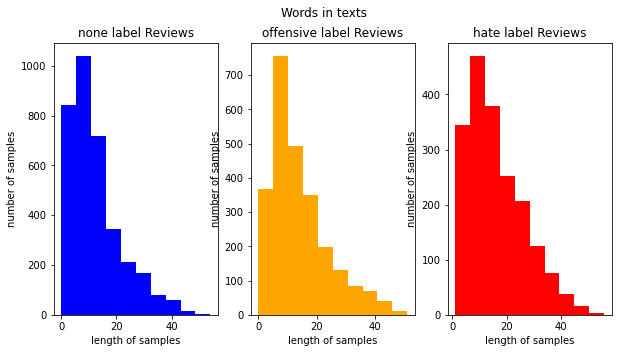

In [214]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5))
text_len = train[train['hate']==0]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='blue')
ax1.set_title('none label Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('none 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train[train['hate']==1]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='orange')
ax2.set_title('offensive label Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('offensive 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train[train['hate']==2]['tokenized'].map(lambda x: len(x))
ax3.hist(text_len, color='red')
ax3.set_title('hate label Reviews')
fig.suptitle('Words in texts')
ax3.set_xlabel('length of samples')
ax3.set_ylabel('number of samples')
print('hate 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [215]:
train_data, test_data = train_test_split(train, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 5922
테스트용 리뷰의 개수 : 1974


In [216]:
train_data.hate.value_counts()

0    2635
1    1859
2    1428
Name: hate, dtype: int64

In [217]:
test_data.hate.value_counts()

0    851
1    640
2    483
Name: hate, dtype: int64

In [218]:
from tensorflow.keras.utils import to_categorical
dataset_y = to_categorical(train_data['hate'])
dataset_y = np.array(dataset_y, dtype=np.int32)
print(dataset_y)

[[1 0 0]
 [0 0 1]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [0 1 0]]


In [219]:
test_y = to_categorical(test_data['hate'])
test_y = np.array(test_y, dtype=np.int32)
print(test_y)

[[0 0 1]
 [1 0 0]
 [0 1 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 0 1]]


In [242]:
X_train = train_data['tokenized'].values
y_train = dataset_y
X_test= test_data['tokenized'].values
y_test = test_y

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5922,), (5922, 3), (1974,), (1974, 3))

In [243]:
X_train

array([list(['이렇게', '재', '밋', '수', '있', '다니']),
       list(['갠', '적', '으로', '이런', '스타일', '싸', '보인다', '.', '....', '스카이', '캐슬', '그런', '적', '스타일', '어울리', '.', '...', '이건', '술집', '여자', '같']),
       list(['나', '보', '기', '불편', '함', '?']), ...,
       list(['그래도', '잘', '조금', '쉬', '나오', '이해', '해', '주', '것', '.', '.', '한국', '외모', '나라', '니까', '다행', '다행', '.', '.', '복귀', '콘서트', '!', '함', '내']),
       list(['한지민', '씨', '제발', '좀', '바꾸', '세요', '.', '엄마', '찾', '으러', '다니', '장면', '에서', '바지', '왜', '그래요', '?', 'ㅠ', '.', 'ㅠ']),
       list(['정용화', ',', '급', '아닌데', '부산', '에서', '누가', 'ㅋㅋ'])],
      dtype=object)

# 정수 인코딩

In [221]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [222]:
tokenizer.word_counts

OrderedDict([('이렇게', 75),
             ('재', 23),
             ('밋', 6),
             ('수', 189),
             ('있', 698),
             ('다니', 58),
             ('갠', 5),
             ('적', 214),
             ('으로', 351),
             ('이런', 130),
             ('스타일', 24),
             ('싸', 18),
             ('보인다', 17),
             ('.', 4670),
             ('....', 53),
             ('스카이', 5),
             ('캐슬', 6),
             ('그런', 69),
             ('어울리', 20),
             ('...', 152),
             ('이건', 22),
             ('술집', 8),
             ('여자', 438),
             ('같', 441),
             ('나', 696),
             ('보', 677),
             ('기', 344),
             ('불편', 34),
             ('함', 104),
             ('?', 1529),
             ('그래도', 53),
             ('너', 72),
             ('할', 238),
             ('줄', 110),
             ('아', 523),
             ('는구나', 33),
             ('송혜교', 27),
             ('측', 3),
             ('아직', 71),
             ('뻔뻔', 

In [225]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 4159
등장 빈도가 1번 이하인 희귀 단어의 수: 526
단어 집합에서 희귀 단어의 비율: 12.647270978600625
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.637637589099549


In [226]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 3635


In [227]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# 패딩

리뷰의 최대 길이 : 56
리뷰의 평균 길이 : 13.929753461668355


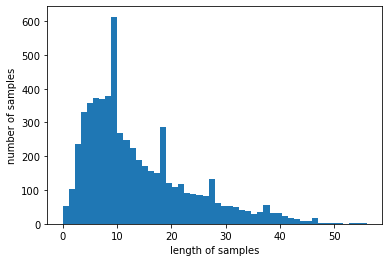

In [228]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [229]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [230]:
max_len = 56
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 56 이하인 샘플의 비율: 100.0


In [231]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# 모델 구축

In [238]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(vocab_size, 200))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(200)))
model.add(Dense(3, activation='softmax'))


In [239]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [240]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=1024, validation_split=0.2)

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 1.1472 - acc: 0.4013
Epoch 00001: val_acc improved from -inf to 0.42025, saving model to best_model.h5
5/5 [==============================] - 11s 2s/step - loss: 1.1472 - acc: 0.4013 - val_loss: 1.0878 - val_acc: 0.4203
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 1.0412 - acc: 0.4473
Epoch 00002: val_acc improved from 0.42025 to 0.43713, saving model to best_model.h5
5/5 [==============================] - 10s 2s/step - loss: 1.0412 - acc: 0.4473 - val_loss: 1.0694 - val_acc: 0.4371
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.9826 - acc: 0.4908
Epoch 00003: val_acc did not improve from 0.43713
5/5 [==============================] - 12s 2s/step - loss: 0.9826 - acc: 0.4908 - val_loss: 1.0652 - val_acc: 0.4371
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.9038 - acc: 0.5930
Epoch 00004: val_acc improved from 0.43713 to 0.43882, saving model to best_mode

Epoch 32/100
5/5 [==============================] - ETA: 0s - loss: 0.0487 - acc: 0.9821
Epoch 00032: val_acc improved from 0.49705 to 0.50549, saving model to best_model.h5
5/5 [==============================] - 11s 2s/step - loss: 0.0487 - acc: 0.9821 - val_loss: 1.1848 - val_acc: 0.5055
Epoch 33/100
5/5 [==============================] - ETA: 0s - loss: 0.0453 - acc: 0.9852
Epoch 00033: val_acc did not improve from 0.50549
5/5 [==============================] - 14s 3s/step - loss: 0.0453 - acc: 0.9852 - val_loss: 1.4850 - val_acc: 0.4734
Epoch 34/100
5/5 [==============================] - ETA: 0s - loss: 0.0514 - acc: 0.9818
Epoch 00034: val_acc did not improve from 0.50549
5/5 [==============================] - 14s 3s/step - loss: 0.0514 - acc: 0.9818 - val_loss: 2.0837 - val_acc: 0.4498
Epoch 35/100
5/5 [==============================] - ETA: 0s - loss: 0.0432 - acc: 0.9869
Epoch 00035: val_acc improved from 0.50549 to 0.50802, saving model to best_model.h5
5/5 [==================

In [148]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

62/62 [==============================] - 1s 22ms/step - loss: 1.0014 - acc: 0.5041
테스트 정확도: 0.5041


In [106]:
preds = loaded_model.predict(X_test)
preds

array([[0.39774117, 0.4180528 , 0.18420602],
       [0.93720895, 0.05255724, 0.01023376],
       [0.53255975, 0.3266842 , 0.14075604],
       ...,
       [0.27636996, 0.466064  , 0.2575661 ],
       [0.2051393 , 0.4949639 , 0.29989678],
       [0.39454758, 0.3854387 , 0.22001368]], dtype=float32)

# 모델 평가 참고 

- https://ayoteralab.tistory.com/entry/Iris-dataset-classification-with-Keras?category=873956

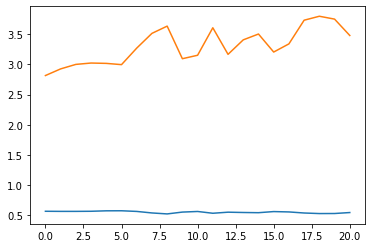

In [139]:
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_loss'])
plt.show()

NameError: name 'dataset' is not defined

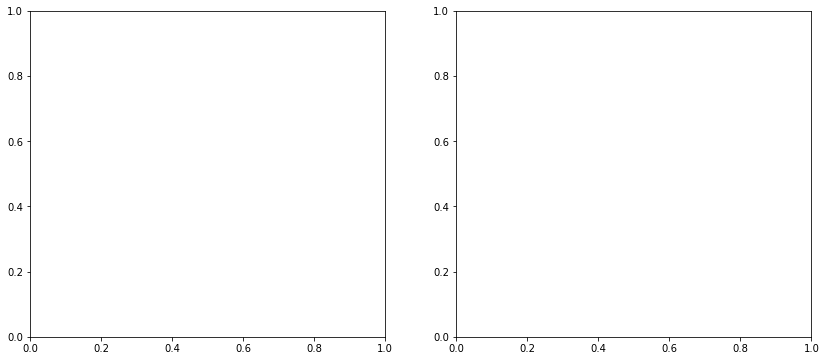

In [108]:
f, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].scatter(dataset.data[:,0], dataset.data[:,1], c=dataset.target)
ax[0].set_title('scatter with Sepal')
ax[1].scatter(dataset.data[:,2], dataset.data[:,3], c=dataset.target)
ax[1].set_title('scatter with Petal')
plt.show()